# Solving Partial Differential Equation with Q-Exponential Process

## Introduction
In this example, we introduce a Bayesian solver to PDE by modeling its solution as a QEP $u\sim \textrm{q-EP}(0, \mathcal C)$. When choosing a differentiable kernel $\mathcal C$, the derivatives of the PDE solution, $\frac{\partial^{\boldsymbol \alpha}}{\partial {\bf x}^{\boldsymbol \alpha}}$, are also QEPs based on the preservation property of linear combination. Assuming a QEP prior, $\textrm{q-EP}(0, \tilde{\mathcal C})$, for the extended function $\tilde u = (u, \frac{\partial}{\partial {\bf x}}, \cdots, \frac{\partial^k}{\partial {\bf x}^k})$, we define the likelihood by penalizing the discrepancy between the left-hand side $P(\tilde u)$ and the right-hand size $h({\bf x})$ of PDE and approximate the posterior using sparse variational Bayes. See more details in our [NIPS2025 paper](https://nips.cc/virtual/2025/loc/san-diego/poster/117572).

In [2]:
import torch
import qpytorch
import random
import numpy as np
import tqdm
from matplotlib import pyplot as plt

%matplotlib inline

# Setting manual seed for reproducibility
seed=2025
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using the '+device+' device...')

Using the cpu device...


## Burgers' Equation
We consider the following Burgers' equation with $\nu=0.1$:

\begin{align}
\frac{\partial}{\partial t} u + u \frac{\partial}{\partial x} u - \nu \frac{\partial^2}{\partial x^2}u &=0, \quad (x, t)\in (-1, 1)\times (0,1], \\
u(x, 0) &= -\sin(\pi x), \quad x \in (-1, 1), \\
u(-1, t) &= u(1,t) = 0, \quad t \in (0,1] .
\end{align}

We first create $25\times 25$ mesh using the following code.

In [3]:
# generate mesh points
def sampled_pts_grid(N_domain, N_boundary, domain, time_dependent = False):
    x1l, x1r = domain[0]
    x2l, x2r = domain[1]
    
    N_pts = int(torch.sqrt(torch.tensor(N_domain + N_boundary)).item()) - 2
    xx = torch.linspace(x1l, x1r, N_pts + 2)
    yy = torch.linspace(x2l, x2r, N_pts + 2)
    XX, YY = torch.meshgrid(xx, yy, indexing='ij')
    
    if not time_dependent:

        XX_int = XX[1:-1, 1:-1]
        YY_int = YY[1:-1, 1:-1]
        
        XXv_bd = torch.cat((XX[:-1, 0], XX[0, :-1], XX[:-1, -1], XX[-1, :-1]))
        YYv_bd = torch.cat((YY[:-1, 0], YY[0, :-1], YY[:-1, -1], YY[-1, :-1]))
        
    else:

        XX_int = XX[1:-1, 1:]
        YY_int = YY[1:-1, 1:]
        
        XXv_bd = torch.cat((XX[-1,1:], XX[:, 0], XX[0, 1:]))
        YYv_bd = torch.cat((YY[-1,1:], YY[:, 0], YY[0, 1:]))
    
    # vectorized (x,y) coordinates
    XXv_int = XX_int.flatten().unsqueeze(1)
    YYv_int = YY_int.flatten().unsqueeze(1)
    
    XXv_bd = XXv_bd.unsqueeze(1)
    YYv_bd = YYv_bd.unsqueeze(1)
    
    X_domain = torch.cat((XXv_int, YYv_int), dim=1)
    X_boundary = torch.cat((XXv_bd, YYv_bd), dim=1)
    return X_domain, X_boundary

Now on the mesh with $N=N_d+N_b$ points of which $N_d$ are in the domain and $N_b$ are on the boundary, we have the extended function `mu` as an $N\times D$ array where $D=1+kd$ with max $k=2$ order derivatives and $d=2$ physical dimensions. Define the PDE class to specify the left-hand function `lhs_f`, the right-hand function `rhs_f`, the boundary condition `bdy_g`, and extract the solution/derivatives in the domain and on the boundary respectively.

In [4]:
# PDE class
class Burgers(object):
    def __init__(self, alpha=1.0, nu=0.02, domain=np.array([[-1, 1], [0, 1]])):
        self.alpha = alpha
        self.nu = nu
        self.rhs_f = lambda x: torch.zeros(x.shape[0])
        self.bdy_g = lambda x: (-torch.sin(torch.pi*x[:,:-1].squeeze()) * (x[:,-1]==0) + 0*((x[:,0]==1)+(x[:,0]==-1)))
        self.domain = domain
        self.dim = self.domain.shape[0]

    def sampled_pts(self, N_domain, N_boundary, sampled_type='random'):
        Xd, Xb = sampled_pts_grid(N_domain, N_boundary, self.domain, time_dependent=True)
        if sampled_type == 'random':
            Xd += torch.randn(*Xd.shape) * 1e-2
        elif sampled_type == 'grid':
            pass
        self.X_domain = Xd
        self.X_boundary = Xb
        self.Nd, self.Nb = self.X_domain.shape[0], self.X_boundary.shape[0]
        self.rhs = self.rhs_f(self.X_domain)
        self.bdy = self.bdy_g(self.X_boundary)
    
    def lhs_f(self, u_):
        u_d, u_b, du, d2u_x = self.extract_solution(u_)[0]
        lhs = torch.cat([du[:,-1] + self.alpha*u_d*du[:,:-1].squeeze() - self.nu*d2u_x[:,:self.dim-1].squeeze(),u_b],-1)
        return lhs
    
    def extract_solution(self, mu, var=None):
        u_d, u_b = mu[...,:self.Nd,0], mu[...,self.Nd:,0]
        du = mu[...,:self.Nd,1:1+self.dim]
        d2u_x = mu[...,:self.Nd,1+self.dim:]
        if var is None: var = torch.ones_like(mu)
        v_d, v_b = var[...,:self.Nd,0], var[...,self.Nd:,0]
        dv = var[...,:self.Nd,1:1+self.dim]
        d2v_x = var[...,:self.Nd,1+self.dim:]
        return [u_d, u_b, du, d2u_x], [v_d, v_b, dv, d2v_x]

    def plot_solution(self, u, ax=None, **kwargs):
        import matplotlib.pyplot as plt
        x, t = self.X_domain[:,0], self.X_domain[:,1]
        N_pts = int(np.sqrt(self.Nd+self.Nb))-2
        x = x.reshape((N_pts,N_pts+1))
        t = t.reshape((N_pts,N_pts+1))
        if ax is None:
            ax = plt.gca()
        ctf = ax.contourf(x, t , u, **kwargs)
        clb = plt.colorbar(ctf, ax=ax)
        clb.ax.tick_params(labelsize = ax.yaxis.get_tick_params()['labelsize'])

# generate PDE
alpha = 1.0
nu = 0.1
domain=np.array([[-1, 1], [0, 1]])
N_dom, N_bdy = 625, 100
burgers = Burgers(alpha, nu, domain)
burgers.sampled_pts(N_dom, N_bdy, sampled_type='grid')
burgers_X = torch.cat([burgers.X_domain,burgers.X_boundary]).type(torch.float).to(device)
lims = torch.from_numpy(domain.T)

## Reference solution
As a reference, we solve the Burgers' equation using highly-resolved finite difference method with Cole-Hopf transformation.

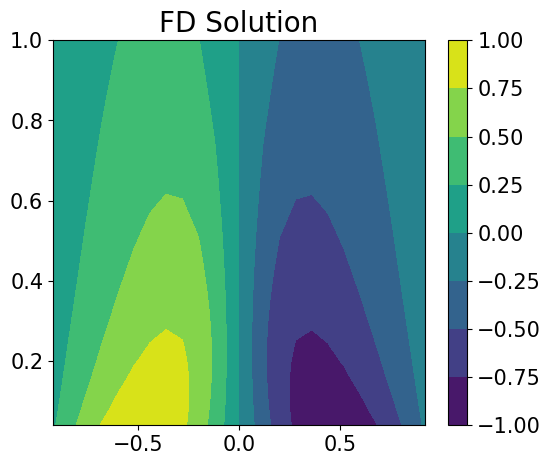

In [5]:
# Solve Burgers' equation using finite difference method.
def u_truth(t, x, nu=0.02):
    [Gauss_pts, weights] = np.polynomial.hermite.hermgauss(80)
    temp = x - np.sqrt(4 * nu * t) * Gauss_pts
    val1 = weights * np.sin(np.pi * temp) * np.exp(-np.cos(np.pi * temp) / (2 * np.pi * nu))
    val2 = weights * np.exp(-np.cos(np.pi * temp) / (2 * np.pi * nu))
    return - val1.sum(axis=1) / val2.sum(axis=1)

def solve_Burgers(n, nu=0.02):
    t = np.linspace(0, 1, n+2)
    x = np.linspace(-1, 1, n+2)
    tt, xx = np.meshgrid(t, x)
    tx = np.vstack([tt.flatten(), xx.flatten()])
    u = u_truth(tx[0].reshape(-1, 1), tx[1].reshape(-1, 1), nu)
    return np.stack([tt, xx, u.reshape(n+2, n+2)])

N_pts = int(np.sqrt(burgers.Nd+burgers.Nb))-2
txu = solve_Burgers(N_pts, nu)
txu = txu[:, 1:-1, 1:]
u_FD = txu[2]

# plot
plt.figure(figsize=(6,5))
plt.tick_params(axis='both', which='major', labelsize=15)
plt.contourf(txu[1], txu[0], u_FD)#, 50)#, cmap='inferno')
clb = plt.colorbar()
clb.ax.tick_params(labelsize=15)
plt.title("FD Solution", fontsize=20)

None

## Setting up the model
We model the extended function $\tilde u$ using some variational distribution $\textrm{q-ED}(\mu, \Sigma)$. With nonlinear left-hand side function $P$, $P(\tilde u)$ no longer follows q-exponential distribution. QPyTorch has `PDESolver` model to propagate the variational distribution $\textrm{q-ED}(\mu, \Sigma)$ through the PDE by linearizing $P$:

\begin{align}
P(\tilde{u}) &\approx P(\tilde{u}_0) + \nabla P(\tilde{u}_0)(\tilde{u}-\tilde{u}_0) \sim \textrm{q-ED}(\mu_*, \Sigma_*), \\
\mu_* &= P(\tilde{u}_0) + \nabla P(\tilde{u}_0)(\mu-\tilde{u}_0), \quad \Sigma_* = P(\tilde{u}_0) \Sigma P(\tilde{u}_0)^{\mathsf T} + \delta I.
\end{align}
where the reference point can be chosen as $\tilde{u}_0=\mu$, and $\delta>0$ is a small nugget added to make the propagated covariance postive definite.

The `PDESolver` class inherits from `ApproximateQEP` to approximate the posterior with sparse variatinoal Bayes. To faciliate modeling derivatives and differential equations, QPyTorch defines new methods including `Matern32KernelGrad`, `Matern52KernelGradGrad`, `RQKernelGrad`, and `RQKernelGradGrad` which are not available in GPyTorch.

In [6]:
# QEP solver
POWER = 1.0
class QEPsolver(qpytorch.models.PDESolver):
        def __init__(self, pde_lhs, power=torch.tensor(1.0), num_inducing=256):
            self.power = power
            input_dims = burgers.dim
            output_dims = input_dims*2
            
            # inducing_points = lims[0] + torch.rand(num_inducing, input_dims) * lims.diff(dim=0)
            inducing_points = burgers_X[torch.randperm(burgers_X.size(0))[:num_inducing]]
            batch_shape = torch.Size([output_dims])
            variational_distribution = qpytorch.variational.NaturalVariationalDistribution(
                num_inducing_points=num_inducing,
                batch_shape=batch_shape,
                power=self.power
            )
            variational_strategy = qpytorch.variational.MultitaskVariationalStrategy(
                self,
                inducing_points,
                variational_distribution,
                learn_inducing_locations=True,
                # jitter_val = 1.0e-4
            )
            
            super().__init__(pde_lhs, variational_strategy)
            # self.mean_module = qpytorch.means.ConstantMeanGradGrad()
            self.mean_module = qpytorch.means.LinearMeanGradGrad(input_dims)
            # self.base_kernel = qpytorch.kernels.RBFKernelGradGrad(ard_num_dims=input_dims, interleaved=False)
            # self.base_kernel = qpytorch.kernels.RQKernelGradGrad(ard_num_dims=input_dims, interleaved=False)
            self.base_kernel = qpytorch.kernels.Matern52KernelGradGrad(ard_num_dims=input_dims, eps=1e-4, interleaved=False)
            self.covar_module = qpytorch.kernels.ScaleKernel(self.base_kernel)
            self.covar_module.base_kernel.register_constraint("raw_lengthscale", qpytorch.constraints.Interval(1e-2, 1))
    
        def forward(self, x):
            N = x.shape[-2]
            mean_x = self.mean_module(x) # ... x N x (2D+1)
            covar_x = self.covar_module(x)# ... x N(2D+1) x N(2D+1)
            mean_x = mean_x[...,:-1]
            covar_x = covar_x[...,:-N,:-N]
            return qpytorch.distributions.MultitaskMultivariateQExponential(mean_x, covar_x, power=self.power, interleaved=False)
        
        def predict(self, testX):
            with torch.no_grad():
                output = self(testX)
                if type(likelihood) is qpytorch.likelihoods.QExponentialLikelihood:
                    output = output.to_data_uncorrelated_dist()
                predictions = likelihood(output)
                pred_m = predictions.mean
                pred_v = predictions.variance
                if pred_m.ndim == 3: pred_m = pred_m.mean(0)
                if pred_v.ndim == 3: pred_v = pred_v.mean(0)
            return pred_m, pred_v

# likelihood
likelihood = qpytorch.likelihoods.QExponentialLikelihood(power=torch.tensor(POWER), noise_constraint=qpytorch.constraints.Interval(1e-2,1.0))
likelihood.noise = torch.tensor(0.02)
# define the model
model = QEPsolver(pde_lhs=burgers.lhs_f, power=torch.tensor(POWER))
model.covar_module.base_kernel.lengthscale = torch.tensor([.25,.5] if POWER>1.0 else [0.15, 0.2])
# set device
model = model.to(device)
likelihood = likelihood.to(device)

## Training

We use the variational inference with natural gradient descent as in this [NGD example](../04_Variational_and_Approximate_QEPs/Natural_Gradient_Descent.ipynb).

In [7]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
num_iter = 2 if smoke_test else 200

# "Loss" for QEPs - the marginal log likelihood
mll = qpytorch.mlls.VariationalELBO(likelihood, model, num_data=burgers.Nd+burgers.Nb)

# Use the adam optimizer
variational_ngd_optimizer = qpytorch.optim.NGD(model.variational_parameters(), num_data=burgers.Nd+burgers.Nb, lr=0.01)
hyperparameter_optimizer = torch.optim.Adam([
    {'params': model.hyperparameters()},
    {'params': likelihood.parameters()},
], lr=0.001)

# Find optimal model hyperparameters
model.train()
likelihood.train()

iterator = tqdm.notebook.tqdm(range(num_iter))
for i in iterator:
    variational_ngd_optimizer.zero_grad()
    hyperparameter_optimizer.zero_grad()
    with qpytorch.settings.cholesky_jitter(double_value=1e-3):
        output = model(burgers_X)
        u0 = output.mean.detach().clone()
        ppgt_dist = model.propagate(output, u0, interleaved=model.base_kernel._interleaved)
        loss = -mll(ppgt_dist, torch.cat([burgers.rhs, burgers.bdy],-1).to(device)).sum()
    loss.backward()
    iterator.set_postfix(loss=loss.item(), lengthscales=model.covar_module.base_kernel.lengthscale.detach().numpy(), noise=likelihood.noise.item())
    # print("Iter %d/%d - Loss: %.3f   lengthscales: %.3f, %.3f   noise: %.3f" % (
    #     i + 1, training_iter, loss.item(),
    #     model.covar_module.base_kernel.lengthscale.squeeze()[0].mean(),
    #     model.covar_module.base_kernel.lengthscale.squeeze()[1].mean(),
    #     likelihood.noise.item()
    # ))
    variational_ngd_optimizer.step()
    hyperparameter_optimizer.step()

  0%|          | 0/200 [00:00<?, ?it/s]

/Users/shiweilan/Projects/QPyTorch/qpytorch/distributions/multivariate_qexponential.py:475: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


## Prediction
Model predictions are also similar to QEP regression, but we have the uncertainty of the solution at the same time.

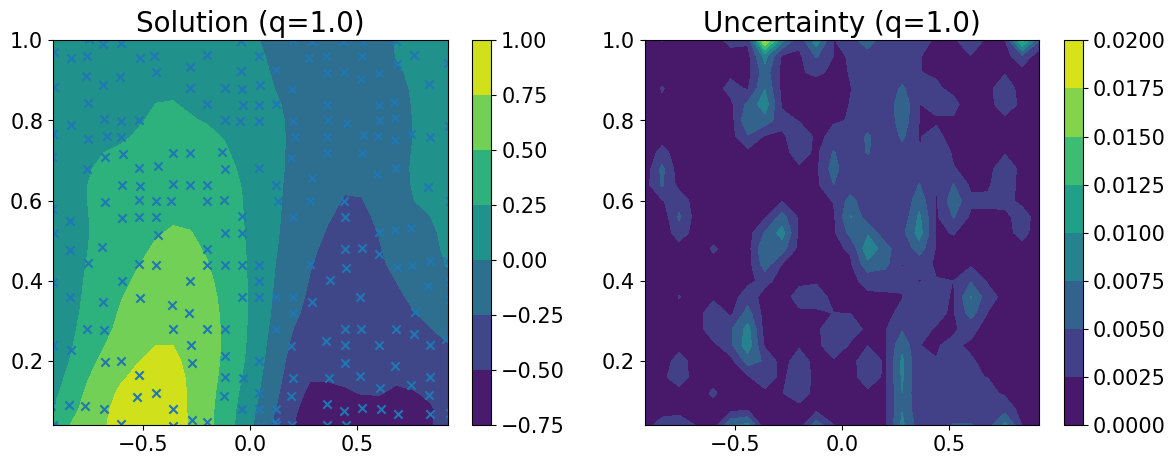

In [8]:
# Set into eval mode
model.eval()
likelihood.eval()

# prepare quantites to plot
pred1_m, pred1_v = output.mean, output.variance
N_pts = int(np.sqrt(burgers.Nd+burgers.Nb))-2

# Initialize plots
fig, axes = plt.subplots(1,2, figsize=(14,5))

# solution
u = burgers.extract_solution(pred1_m)[0][0].detach().cpu()
axes.flat[0].tick_params(axis='both', which='major', labelsize=15)
burgers.plot_solution(u.reshape((N_pts,N_pts+1)), ax=axes.flat[0])#, levels=50)
induc_pts = model.variational_strategy.inducing_points.detach().cpu()
axes.flat[0].autoscale(False)
axes.flat[0].scatter(induc_pts[:,0],induc_pts[:,1], marker='x')
axes.flat[0].set_title('Solution (q='+str(round(POWER,1))+')', fontsize=20)
# uncertainty
v = burgers.extract_solution(pred1_v)[0][0].detach().cpu()
axes.flat[1].tick_params(axis='both', which='major', labelsize=15)
burgers.plot_solution(v.reshape((N_pts,N_pts+1)), ax=axes.flat[1])#, levels=50)
axes.flat[1].set_title('Uncertainty (q='+str(round(POWER,1))+')', fontsize=20)

None

One can try for longer time to obtain solution with improved precision. Refer to the [NIPS2025 paper](https://nips.cc/virtual/2025/loc/san-diego/poster/117572).